In [1]:
import json
from pathlib import Path

# Define the base directory (assumes you're running from the parent of "output")
base_dir = Path("output")

# Nested dictionary to store all JSON data
# Structure: data[dataset][method_variant][file_key] = JSON content
data = {}

for dataset_path in sorted(base_dir.iterdir()):
    if dataset_path.is_dir():
        dataset_name = dataset_path.name
        data[dataset_name] = {}
        # Each dataset has subdirectories (e.g. "drop_col"/"drop_cell", "pretrained", "shuffle_col")
        for method_path in sorted(dataset_path.iterdir()):
            if method_path.is_dir():
                method_name = method_path.name
                data[dataset_name][method_name] = {}
                # Load every JSON file in the method directory
                for json_file in sorted(method_path.glob("*.json")):
                    # Use the file name (without .json) as the key
                    file_key = json_file.stem
                    with open(json_file, "r") as f:
                        data[dataset_name][method_name][file_key] = json.load(f)

# (Optional) Print a summary of what was loaded:
print("Loaded datasets and method variants:")
for dataset, methods in data.items():
    print(f"- {dataset}:")
    for method, files in methods.items():
        print(f"    {method} ({len(files)} files)")

Loaded datasets and method variants:
- santos:
    drop_col (15 files)
    pretrained (15 files)
    shuffle_col (15 files)
- tus:
    drop_cell (14 files)
    pretrained (15 files)
    shuffle_col (15 files)
- tusLarge:
    drop_cell (15 files)
    pretrained (15 files)
    shuffle_col (15 files)


# HEARTS vs Starmie (original truncated datasets)
HEARTS (cluster, faiss mean, faiss max) VS Starmie (bounds, hnsw, lsh)

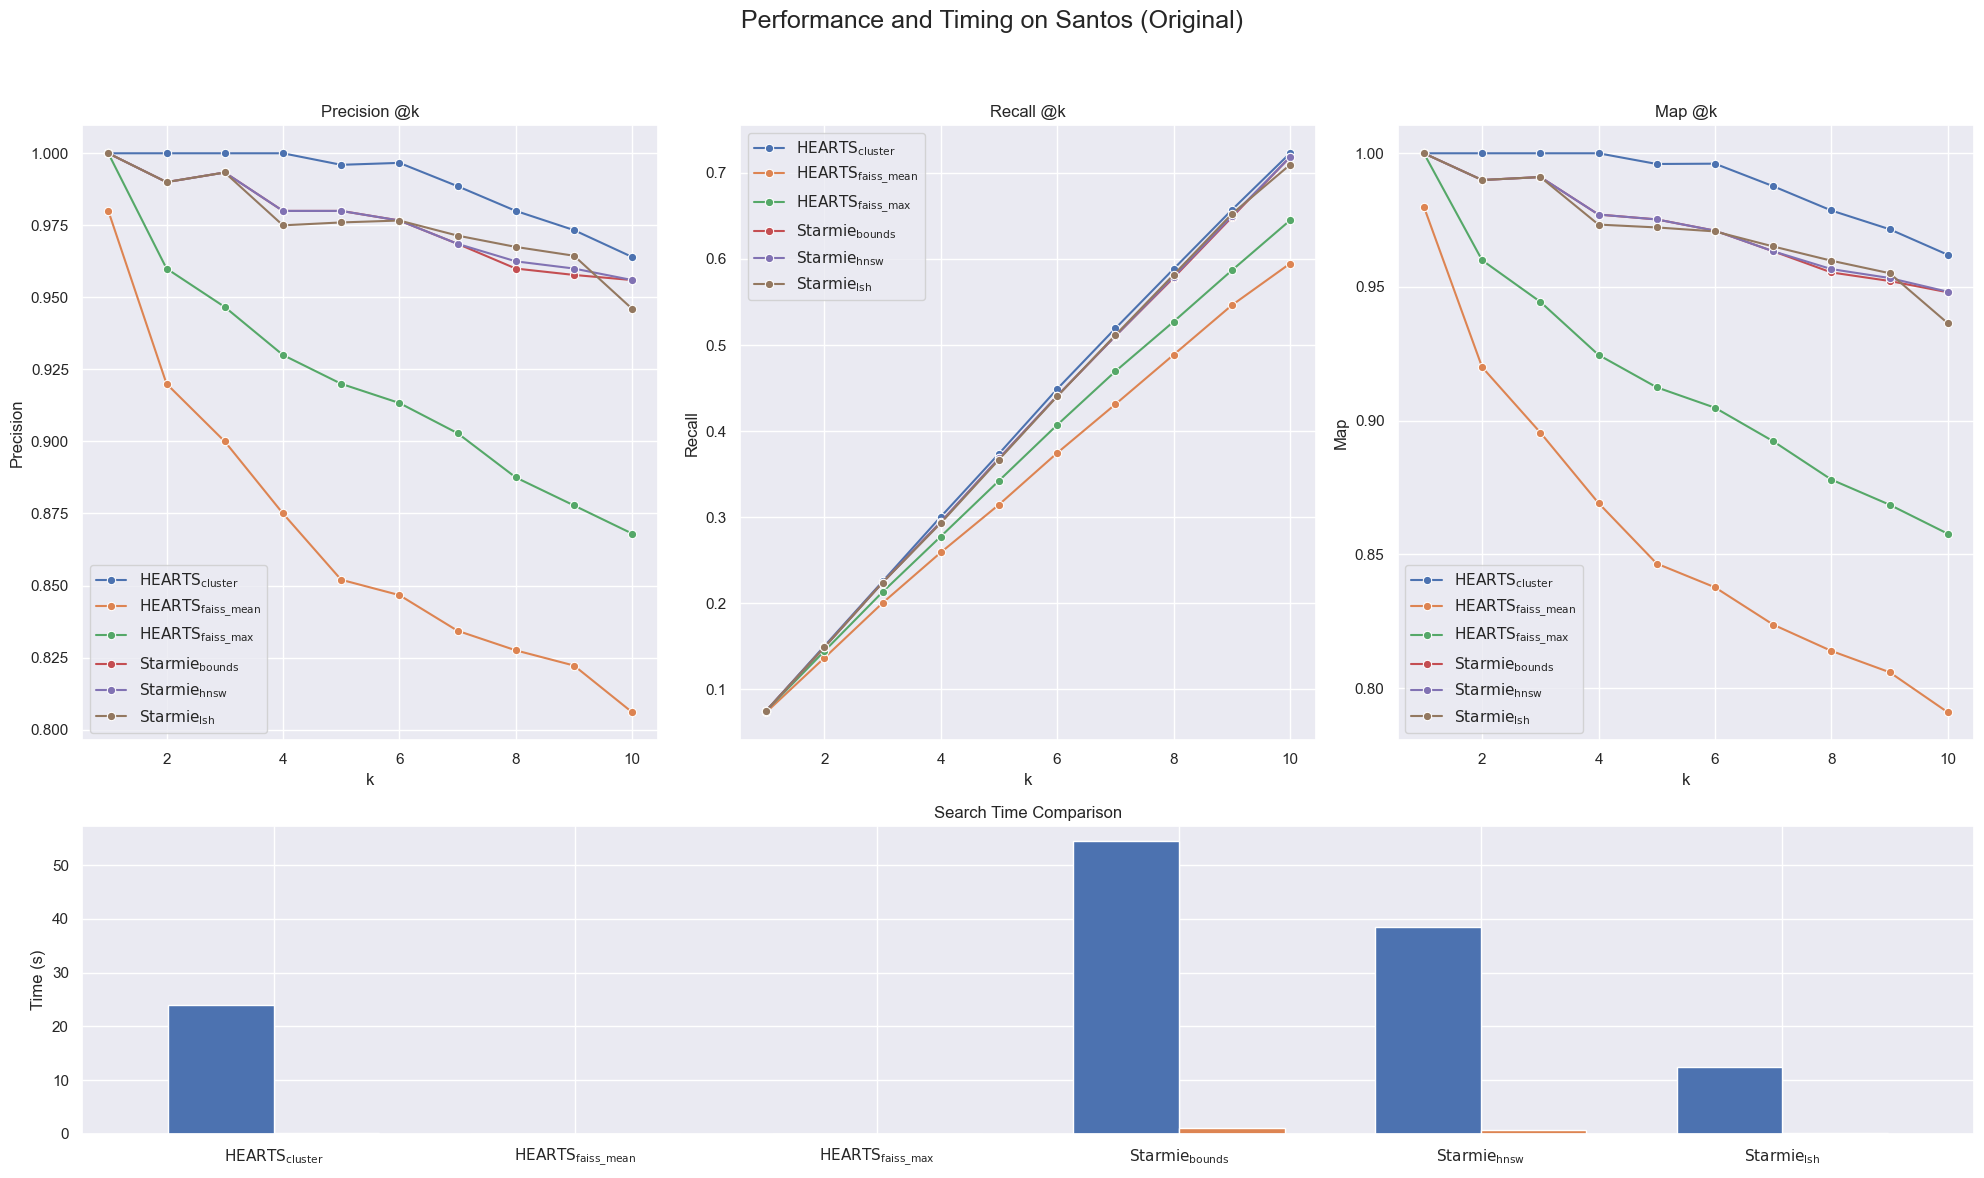

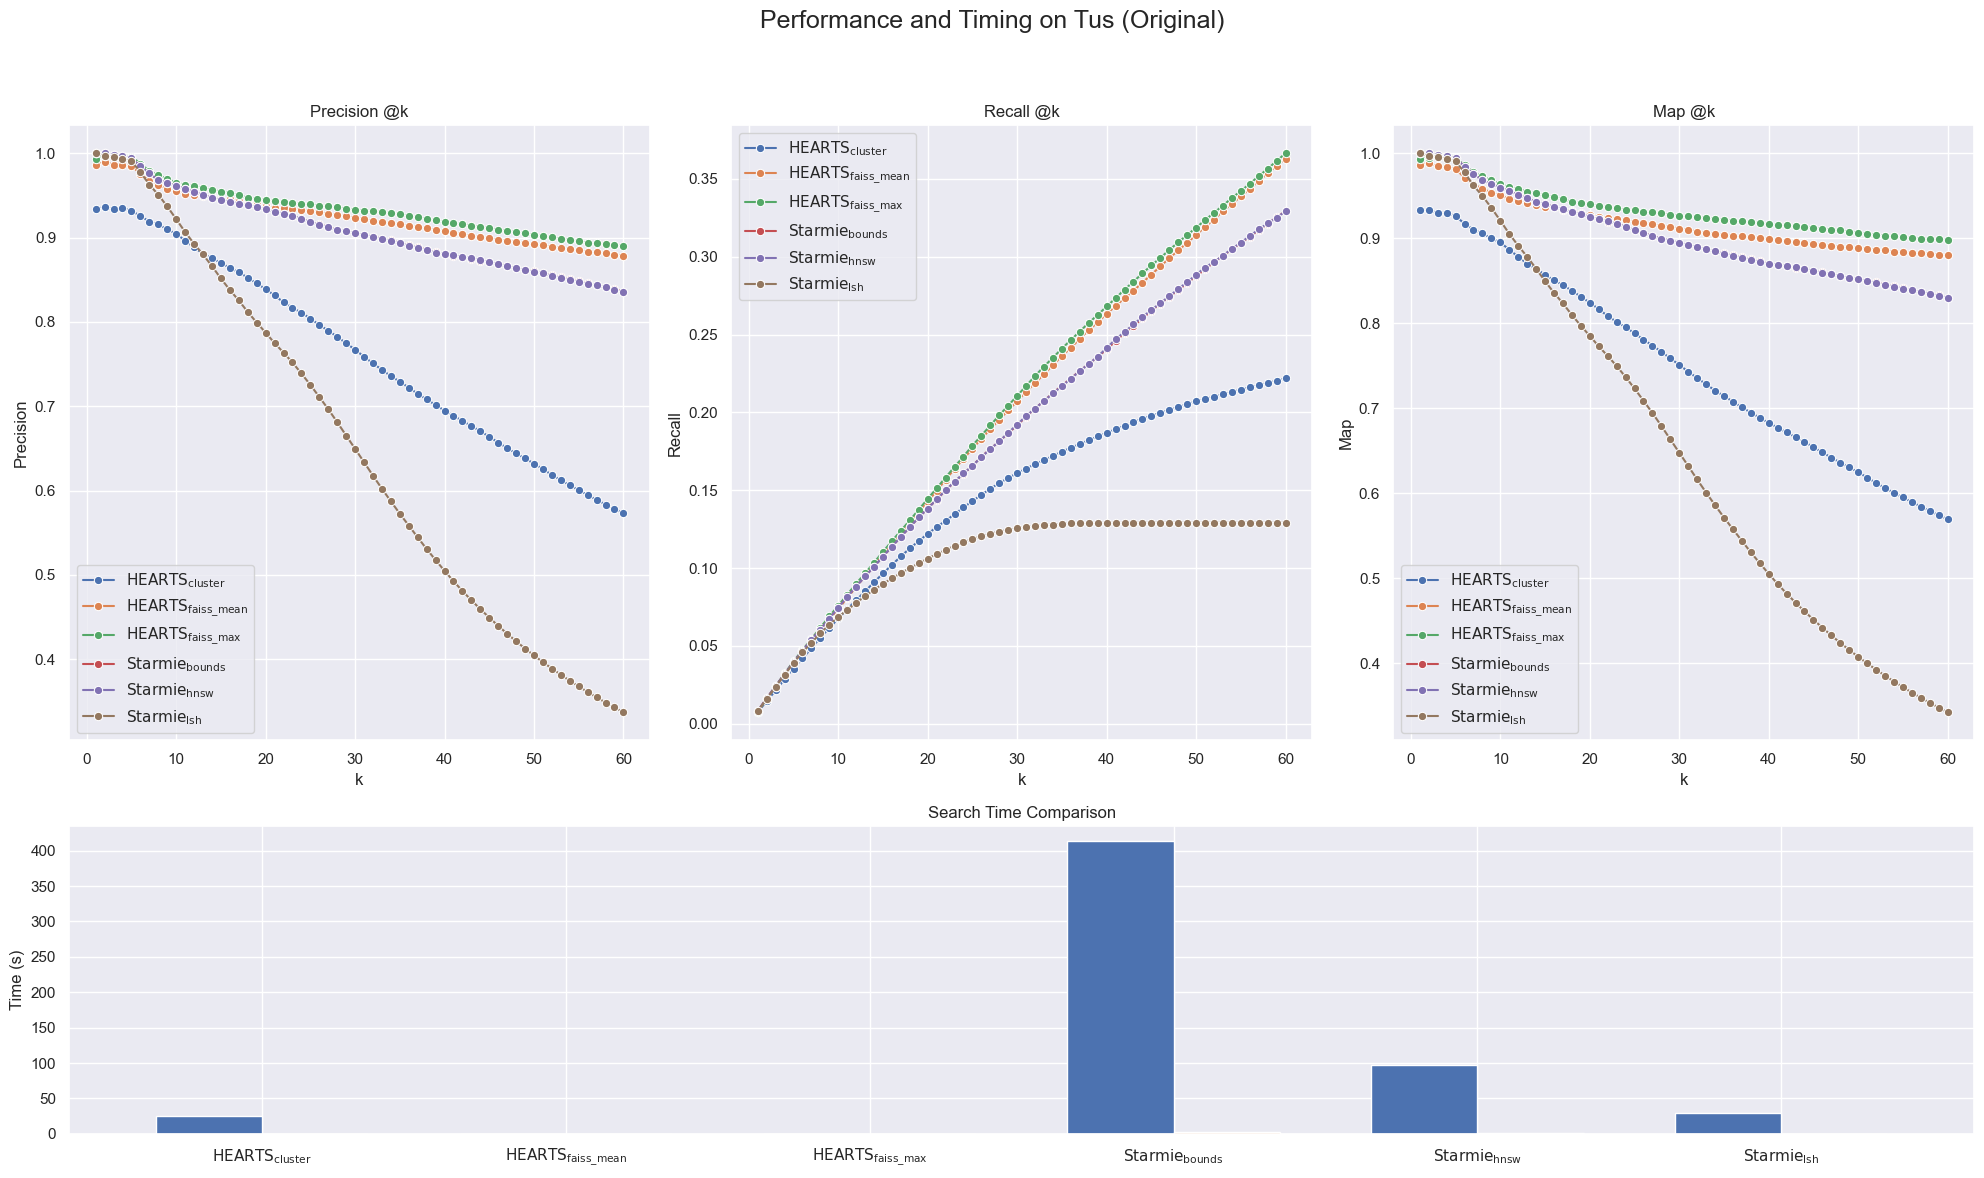

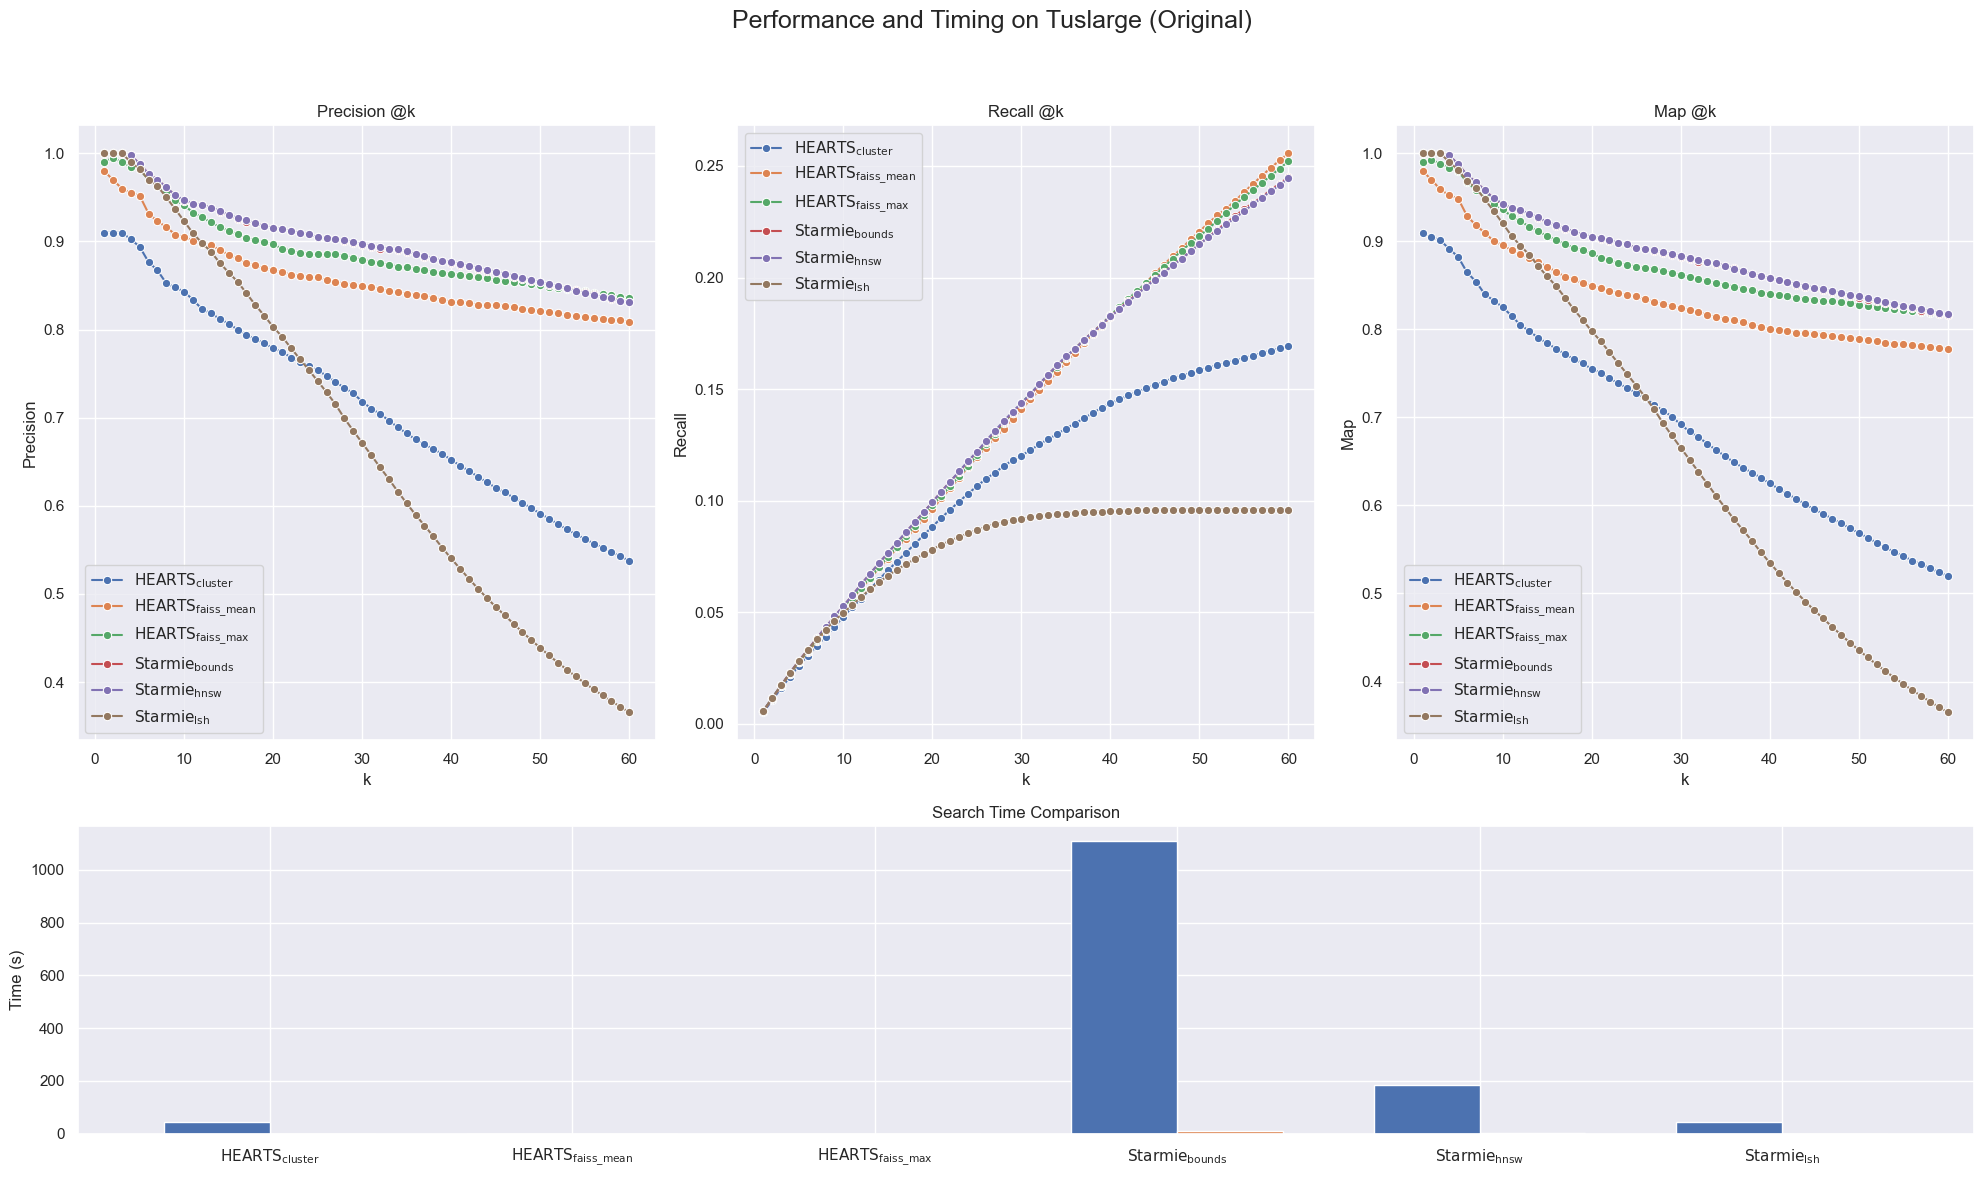

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Use seaborn dark grid style
sns.set_theme(style="darkgrid")

# Define datasets to process (original metrics only)
datasets = ["santos", "tus", "tusLarge"]

for dataset in datasets:
    # Select starmie folder based on dataset: "drop_col" for santos, "drop_cell" for tus and tusLarge.
    if dataset == "santos":
        starmie_folder = "drop_col"
        starmie_suffix = "drop_col"
    else:
        starmie_folder = "drop_cell"
        starmie_suffix = "drop_cell"
    
    # For HEARTS (i.e. HyTrel retrained) we use the "pretrained" folder
    hearts = data[dataset]["pretrained"]
    # For Starmie we use the selected folder
    starmie = data[dataset][starmie_folder]
    
    # Create a dictionary with the new method names (LaTeX strings) mapping to the full JSON content.
    # Each JSON has "system_metrics" (for performance curves) and "search_time" (for timing).
    method_data = {
        r"$\text{HEARTS}_{\text{cluster}}$": hearts["hytrel_metrics_original_cluster"],
        r"$\text{HEARTS}_{\text{faiss\_mean}}$": hearts["hytrel_metrics_original_faiss_mean"],
        r"$\text{HEARTS}_{\text{faiss\_max}}$": hearts["hytrel_metrics_original_faiss_max"],
        r"$\text{Starmie}_{\text{bounds}}$": starmie[f"starmie_metrics_original_bounds_{starmie_suffix}"],
        r"$\text{Starmie}_{\text{hnsw}}$": starmie[f"starmie_metrics_original_hnsw_{starmie_suffix}"],
        r"$\text{Starmie}_{\text{lsh}}$": starmie[f"starmie_metrics_original_lsh_{starmie_suffix}"],
    }
    
    # Determine the range of k values (assumes all methods use the same k-range)
    # (For santos, k = 1...10; for tus and tusLarge, k = 1...60)
    k_range = range(1, len(next(iter(method_data.values()))["system_metrics"]["precision"]) + 1)
    
    # Create a figure with GridSpec:
    # - Top row: three subplots for performance metrics (precision, recall, map)
    # - Bottom row: one subplot (spanning all columns) for the timing comparison.
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(2, 3, height_ratios=[2, 1])
    
    performance_metrics = ["precision", "recall", "map"]
    
    # --- Top row: Plot performance curves ---
    for i, metric in enumerate(performance_metrics):
        ax = fig.add_subplot(gs[0, i])
        for method_name, content in method_data.items():
            sys_metrics = content["system_metrics"]
            values = sys_metrics[metric]
            sns.lineplot(x=list(k_range), y=values, ax=ax, label=method_name, marker="o")
        ax.set_title(f"{metric.capitalize()} @k")
        ax.set_xlabel("k")
        ax.set_ylabel(metric.capitalize())
        # ax.legend(loc="best")
        
    
    # --- Bottom row: Plot search timing as a grouped bar chart ---
    ax_time = fig.add_subplot(gs[1, :])
    
    method_names = list(method_data.keys())
    total_times = []
    avg_query_times = []
    for m in method_names:
        timing = method_data[m]["search_time"]
        total_times.append(timing["total_time"])
        avg_query_times.append(timing["avg_query_time"])
    
    # Create x positions for each group (one group per method)
    x = np.arange(len(method_names))
    width = 0.35  # width of each bar
    
    # Plot bars for total time and average query time
    bars_total = ax_time.bar(x - width/2, total_times, width, label="Total Time")
    bars_avg   = ax_time.bar(x + width/2, avg_query_times, width, label="Avg Query Time")
    
    ax_time.set_xticks(x)
    ax_time.set_xticklabels(method_names)
    ax_time.set_ylabel("Time (s)")
    ax_time.set_title("Search Time Comparison")
    
    # Overall title and layout adjustment
    fig.suptitle(f"Performance and Timing on {dataset.capitalize()} (Original)", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

<Figure size 640x480 with 0 Axes>

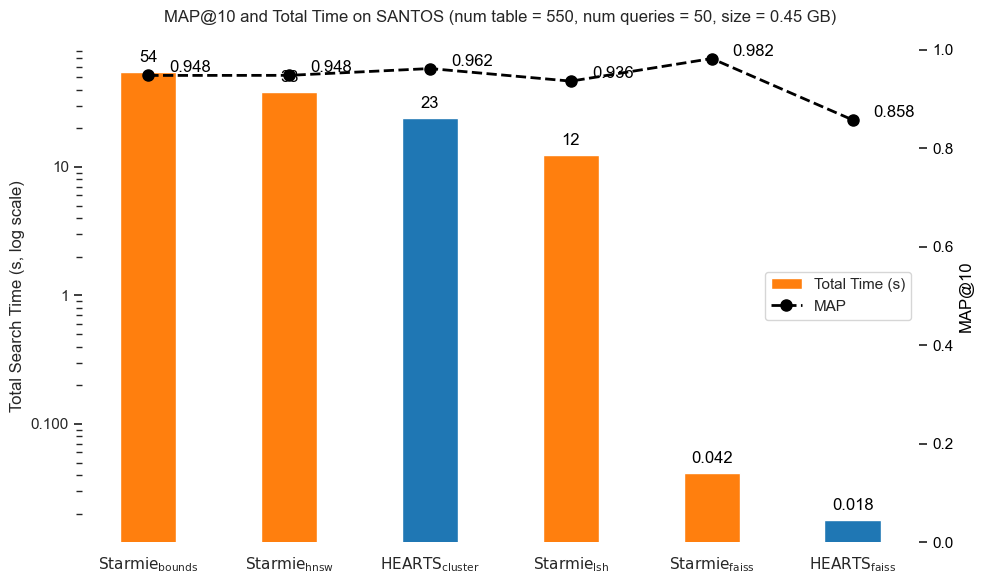

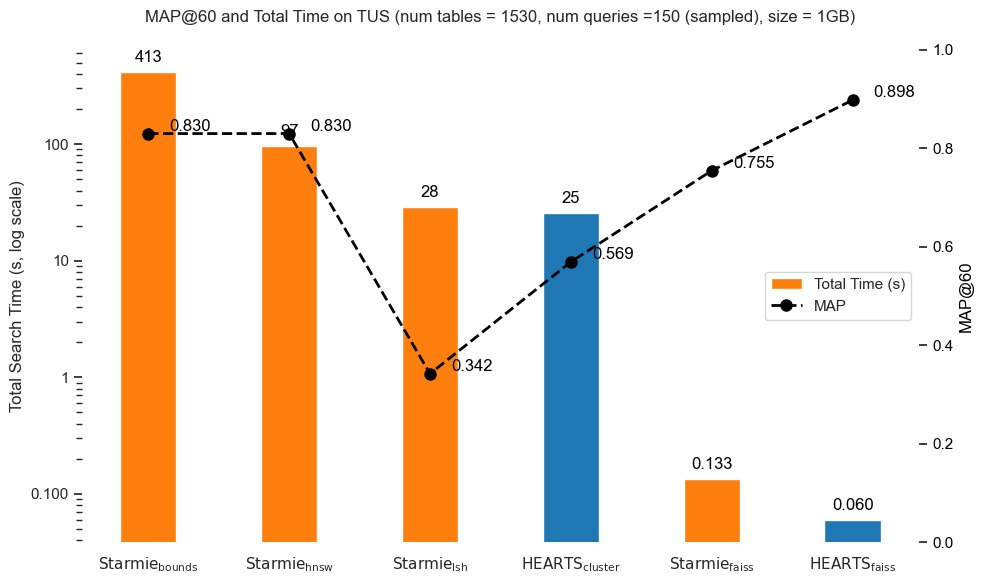

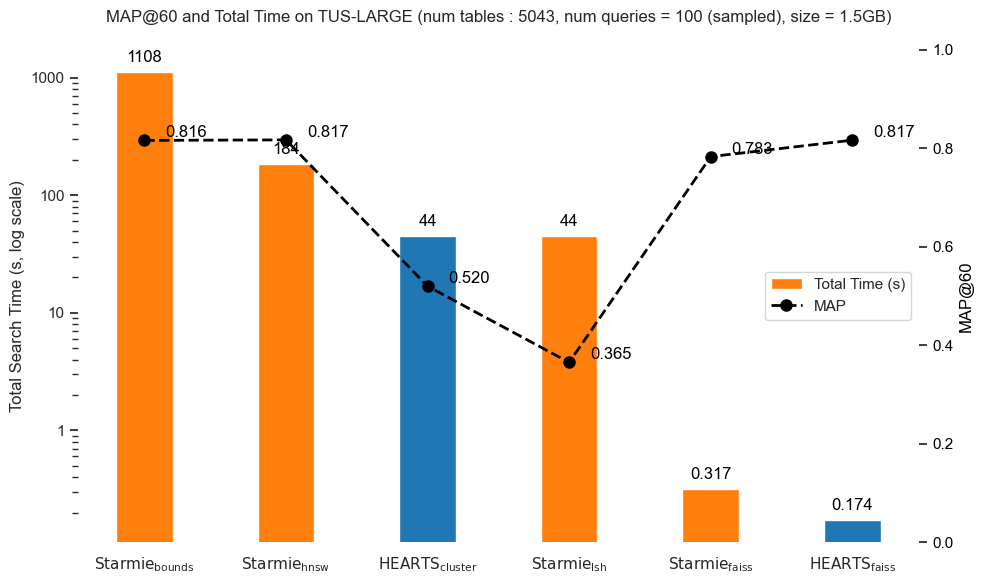

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Set Seaborn's dark grid style
sns.set_theme(style="white")
sns.despine(left=True)

# Custom formatter for log scale: whole numbers for >=1, and 3 decimals for values < 1.
def log_format(x, pos):
    if x >= 1:
        return f"{int(x)}"
    else:
        return f"{x:.3f}"

# Mapping of dataset folder names to display titles
dataset_titles = {"santos": "SANTOS", "tus": "TUS", "tusLarge": "TUS-LARGE"}
dataset_info = {
    "santos": "num table = 550, num queries = 50, size = 0.45 GB",
    "tus": "num tables = 1530, num queries =150 (sampled), size = 1GB",
    "tusLarge": "num tables : 5043, num queries = 100 (sampled), size = 1.5GB"
}
datasets = ["santos", "tus", "tusLarge"]

for dataset in datasets:
    dataset_title = dataset_titles[dataset]
    info_text = dataset_info[dataset]
    
    # Choose the appropriate k index: MAP@10 for SANTOS, MAP@60 for TUS/TUS-LARGE.
    map_index = 9 if dataset == "santos" else 59
    
    # For Starmie: use "drop_col" for SANTOS, "drop_cell" for TUS/TUS-LARGE.
    if dataset == "santos":
        starmie_folder = "drop_col"
        starmie_suffix = "drop_col"
    else:
        starmie_folder = "drop_cell"
        starmie_suffix = "drop_cell"
    
    # Retrieve JSON content for HEARTS (HyTrel retrained) and Starmie.
    hearts = data[dataset]["pretrained"]
    starmie = data[dataset][starmie_folder]
    
    # Build a dictionary of methods with their MAP and total time.
    # For HEARTS, we use the MAP from faiss_max;
    # for Starmie_faiss, we use the MAP from faiss_mean.
    methods = {
        r"$\text{HEARTS}_{\text{cluster}}$": {
            "map": hearts["hytrel_metrics_original_cluster"]["system_metrics"]["map"][map_index],
            "time": hearts["hytrel_metrics_original_cluster"]["search_time"]["total_time"]
        },
        r"$\text{HEARTS}_{\text{faiss}}$": {
            "map": hearts["hytrel_metrics_original_faiss_max"]["system_metrics"]["map"][map_index],
            "time": hearts["hytrel_metrics_original_faiss_max"]["search_time"]["total_time"]
        },
        r"$\text{Starmie}_{\text{bounds}}$": {
            "map": starmie[f"starmie_metrics_original_bounds_{starmie_suffix}"]["system_metrics"]["map"][map_index],
            "time": starmie[f"starmie_metrics_original_bounds_{starmie_suffix}"]["search_time"]["total_time"]
        },
        r"$\text{Starmie}_{\text{hnsw}}$": {
            "map": starmie[f"starmie_metrics_original_hnsw_{starmie_suffix}"]["system_metrics"]["map"][map_index],
            "time": starmie[f"starmie_metrics_original_hnsw_{starmie_suffix}"]["search_time"]["total_time"]
        },
        r"$\text{Starmie}_{\text{lsh}}$": {
            "map": starmie[f"starmie_metrics_original_lsh_{starmie_suffix}"]["system_metrics"]["map"][map_index],
            "time": starmie[f"starmie_metrics_original_lsh_{starmie_suffix}"]["search_time"]["total_time"]
        },
        r"$\text{Starmie}_{\text{faiss}}$": {
            "map": starmie[f"starmie_metrics_original_faiss_{starmie_suffix}_mean"]["system_metrics"]["map"][map_index],
            "time": starmie[f"starmie_metrics_original_faiss_{starmie_suffix}_mean"]["search_time"]["total_time"]
        }
    }
    
    # Sort the methods from most time consuming to least time consuming.
    methods_sorted = dict(sorted(methods.items(), key=lambda item: item[1]["time"], reverse=True))
    
    method_names = list(methods_sorted.keys())
    total_times = [methods_sorted[m]["time"] for m in method_names]
    maps = [methods_sorted[m]["map"] for m in method_names]
    x = np.arange(len(method_names))
    bar_width = 0.4  # width for total time bars

    # Define color palette for pillars: HEARTS in blue, Starmie in orange.
    bar_colors = ["tab:blue" if "HEARTS" in name else "tab:orange" for name in method_names]
    
    # Create a dual-axis figure.
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    
    # Plot total time as colored bars on the primary y-axis (log scale).
    bars = ax1.bar(x, total_times, bar_width, color=bar_colors, label="Total Time (s)")
    ax1.set_yscale("log")
    ax1.yaxis.set_major_formatter(FuncFormatter(log_format))
    ax1.set_ylabel("Total Search Time (s, log scale)")
    ax1.set_xticks(x)
    ax1.set_xticklabels(method_names)
    
    # Plot MAP as red markers with a dashed line on the secondary y-axis.
    ax2.plot(x, maps, color="black", marker="o", linestyle="--", linewidth=2, markersize=8, label="MAP")
    ax2.set_ylabel("MAP@{}".format("10" if dataset=="santos" else "60"), color="black")
    ax2.tick_params(axis='y', labelcolor="black")
    ax2.set_ylim(0, 1)  # MAP values typically range from 0 to 1
    
    # Remove borders
    for spine in ax1.spines.values():
        spine.set_visible(False)
    for spine in ax2.spines.values():
        spine.set_visible(False)
    
    # Annotate total time values on top of each bar.
    for bar in bars:
        height = bar.get_height()
        label = f"{height:.3f}" if height < 1 else f"{int(height)}"
        ax1.annotate(label,
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha="center", va="bottom",
                     color="black")
    
    # Annotate MAP values next to the markers.
    for xi, map_val in zip(x, maps):
        ax2.annotate(f"{map_val:.3f}", 
                     xy=(xi, map_val),
                     xytext=(30, 0),  # 25 points horizontal offset
                     textcoords="offset points",
                     ha="center", va="bottom",
                     color="black")
    
    # Combine legends from both axes.
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")
    
    # Place the title at the bottom
    ax1.set_title(f"MAP@{'10' if dataset=='santos' else '60'} and Total Time on {dataset_title} ({info_text})", pad=20)
    
    plt.tight_layout()
    plt.show()

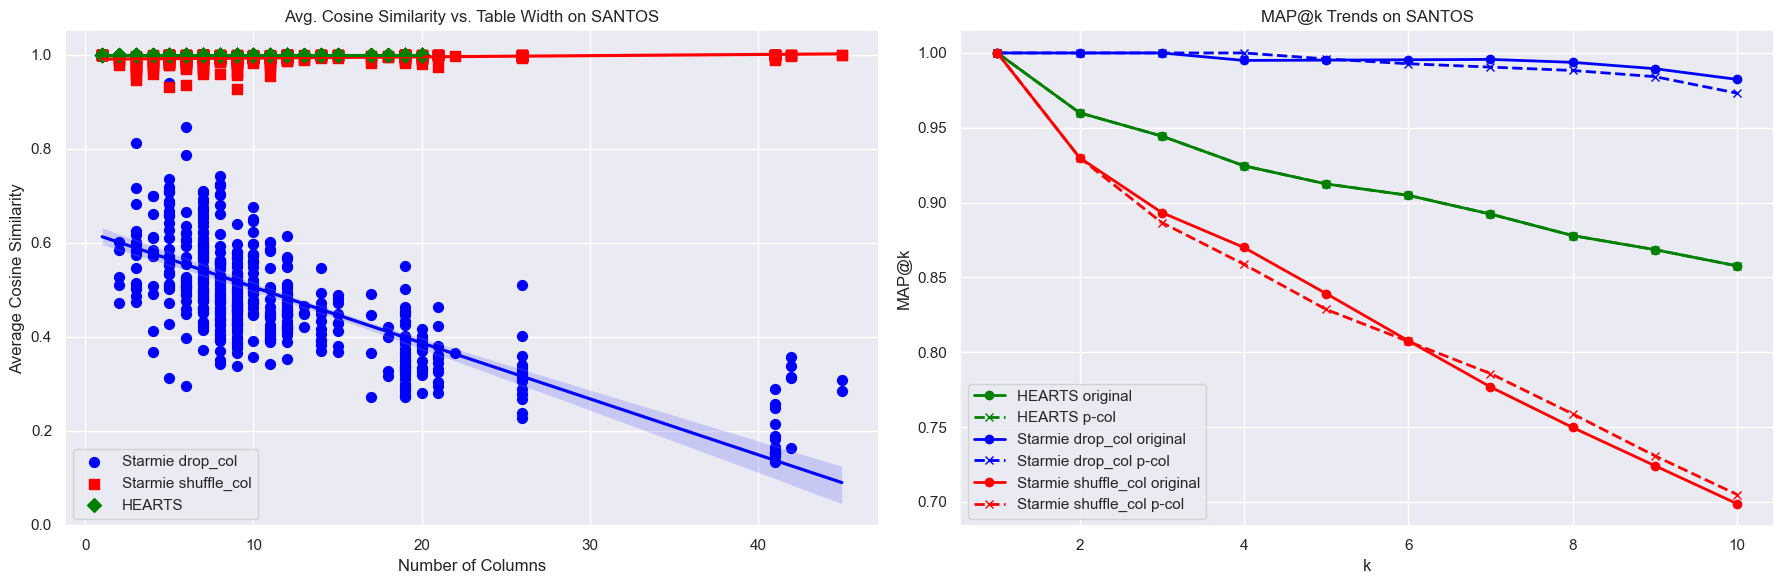

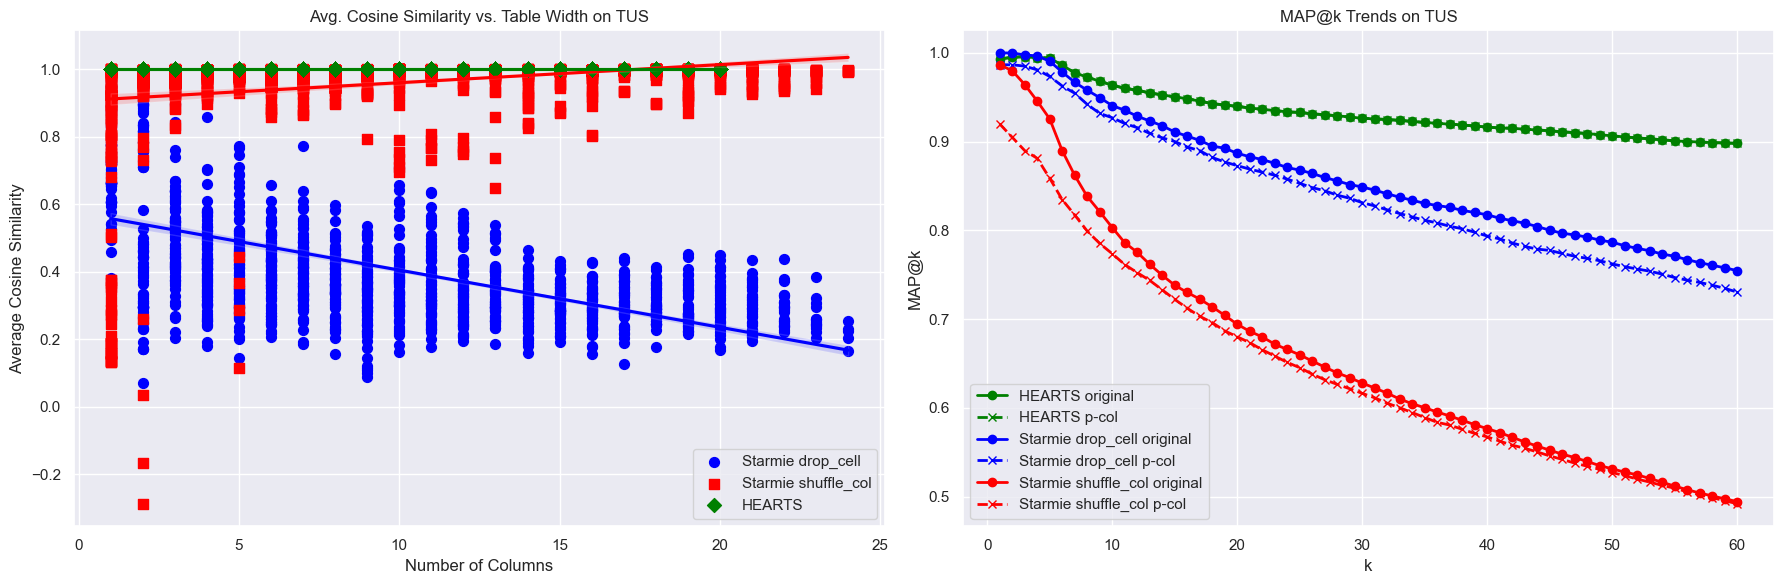

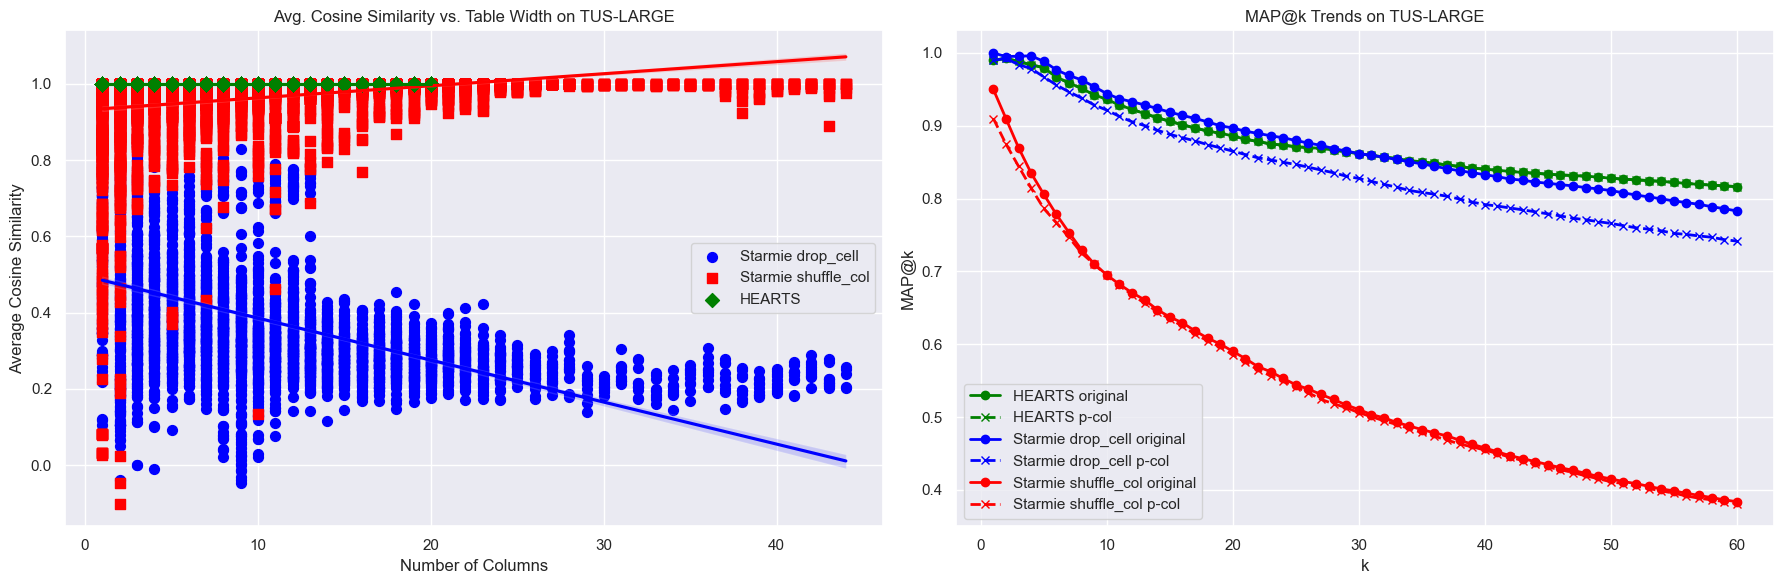

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

sns.set_theme(style="darkgrid")

# Helper: compute average cosine similarity per table.
def avg_cosine(table):
    return statistics.mean([col["cosine_similarity"] for col in table["column_similarities"]])

# Helper: extract (x,y) from a distances JSON (x = num_columns, y = avg cosine similarity).
def extract_points(json_obj):
    xs, ys = [], []
    for table in json_obj["tables"]:
        xs.append(table["num_columns"])
        ys.append(avg_cosine(table))
    return np.array(xs), np.array(ys)

# Define colors for each method.
hearts_color = "green"
starmie_drop_color = "blue"       # drop_col for SANTOS, drop_cell for TUS/TUS-LARGE
starmie_shuffle_color = "red"       # always from shuffle_col

# Mapping of dataset folder names to display titles.
dataset_titles = {"santos": "SANTOS", "tus": "TUS", "tusLarge": "TUS-LARGE"}
datasets = ["santos", "tus", "tusLarge"]

for dataset in datasets:
    dataset_title = dataset_titles[dataset]
    
    # For distances, choose appropriate subfolders:
    starmie_drop_folder = "drop_col" if dataset=="santos" else "drop_cell"
    starmie_shuffle_folder = "shuffle_col"
    hearts_folder = "pretrained"
    
    # Load distances JSONs.
    starmie_drop_json = data[dataset][starmie_drop_folder]["starmie_distances_" + ("drop_col" if dataset=="santos" else "drop_cell")]
    starmie_shuffle_json = data[dataset][starmie_shuffle_folder]["starmie_distances_shuffle_col"]
    hearts_json = data[dataset][hearts_folder]["hytrel_distances"]
    
    # Extract scatter plot points.
    drop_x, drop_y = extract_points(starmie_drop_json)
    shuffle_x, shuffle_y = extract_points(starmie_shuffle_json)
    hearts_x, hearts_y = extract_points(hearts_json)
    
    # For the MAP plots, set k-range.
    # Use MAP@10 for SANTOS, and MAP@60 for TUS/TUS-LARGE.
    map_index = 9 if dataset=="santos" else 59
    k_range = range(1, len(data[dataset][hearts_folder]["hytrel_metrics_original_faiss_max"]["system_metrics"]["map"]) + 1)
    
    # HEARTS MAP arrays (faiss_max): original and p-col.
    hearts_map_orig = data[dataset][hearts_folder]["hytrel_metrics_original_faiss_max"]["system_metrics"]["map"]
    hearts_map_pcol = data[dataset][hearts_folder]["hytrel_metrics_p-col_faiss_max"]["system_metrics"]["map"]
    
    # Starmie Drop MAP arrays (faiss_mean).
    if dataset=="santos":
        starmie_drop_map_orig = data[dataset][starmie_drop_folder]["starmie_metrics_original_faiss_drop_col_mean"]["system_metrics"]["map"]
        starmie_drop_map_pcol = data[dataset][starmie_drop_folder]["starmie_metrics_p-col_faiss_drop_col_mean"]["system_metrics"]["map"]
    else:
        starmie_drop_map_orig = data[dataset][starmie_drop_folder]["starmie_metrics_original_faiss_drop_cell_mean"]["system_metrics"]["map"]
        starmie_drop_map_pcol = data[dataset][starmie_drop_folder]["starmie_metrics_p-col_faiss_drop_cell_mean"]["system_metrics"]["map"]
    
    # Starmie Shuffle MAP arrays (faiss_mean).
    starmie_shuffle_map_orig = data[dataset][starmie_shuffle_folder]["starmie_metrics_original_faiss_shuffle_col_mean"]["system_metrics"]["map"]
    starmie_shuffle_map_pcol = data[dataset][starmie_shuffle_folder]["starmie_metrics_p-col_faiss_shuffle_col_mean"]["system_metrics"]["map"]
    
    # Create a figure with two subplots side-by-side.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # --- Subplot 1: Scatter Plot (Distances) ---
    ax1.scatter(drop_x, drop_y, marker="o", color=starmie_drop_color, s=50,
                label=f"Starmie {starmie_drop_folder}")
    ax1.scatter(shuffle_x, shuffle_y, marker="s", color=starmie_shuffle_color, s=50,
                label="Starmie shuffle_col")
    ax1.scatter(hearts_x, hearts_y, marker="D", color=hearts_color, s=50,
                label="HEARTS")
    # Add regression lines.
    sns.regplot(x=drop_x, y=drop_y, scatter=False, ax=ax1, color=starmie_drop_color)
    sns.regplot(x=shuffle_x, y=shuffle_y, scatter=False, ax=ax1, color=starmie_shuffle_color)
    sns.regplot(x=hearts_x, y=hearts_y, scatter=False, ax=ax1, color=hearts_color)
    
    ax1.set_xlabel("Number of Columns")
    ax1.set_ylabel("Average Cosine Similarity")
    ax1.set_title(f"Avg. Cosine Similarity vs. Table Width on {dataset_title}")
    ax1.legend(loc="best")
    
    # --- Subplot 2: MAP@k Trends ---
    # HEARTS curves (using faiss_max): original (solid) and p-col (dashed).
    ax2.plot(list(k_range), hearts_map_orig, marker="o", color=hearts_color, linestyle="-", linewidth=2,
         label="HEARTS original")
    ax2.plot(list(k_range), hearts_map_pcol, marker="x", color=hearts_color, linestyle="--", linewidth=2,
            label="HEARTS p-col")

    ax2.plot(list(k_range), starmie_drop_map_orig, marker="o", color=starmie_drop_color, linestyle="-", linewidth=2,
            label=f"Starmie {starmie_drop_folder} original")
    ax2.plot(list(k_range), starmie_drop_map_pcol, marker="x", color=starmie_drop_color, linestyle="--", linewidth=2,
            label=f"Starmie {starmie_drop_folder} p-col")

    ax2.plot(list(k_range), starmie_shuffle_map_orig, marker="o", color=starmie_shuffle_color, linestyle="-", linewidth=2,
            label="Starmie shuffle_col original")
    ax2.plot(list(k_range), starmie_shuffle_map_pcol, marker="x", color=starmie_shuffle_color, linestyle="--", linewidth=2,
            label="Starmie shuffle_col p-col")
    
    ax2.set_xlabel("k")
    ax2.set_ylabel("MAP@k")
    ax2.set_title(f"MAP@k Trends on {dataset_title}")
    ax2.legend(loc="best")
    
    plt.tight_layout()
    plt.show()